In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Example: Unzip into the current working directory - since i have a zip in my drive and i want to unzip into my colab env for faster access
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 79.6 MB/s eta 0:00:00


In [ ]:
# Standard Library Imports
import os
import random
import shutil
import warnings
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
# Image Processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import rasterio
from PIL import Image
import PIL
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import AdamW
import keras_cv
keras.mixed_precision.set_global_policy("mixed_float16")
# Progress Bars
import tqdm
from tqdm.auto import trange, tqdm
# Evaluation Metrics
import sklearn
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend


In [ ]:
IMAGE_SIZE = (224,224) #For MobileNetV3Large
BATCH_SIZE = 32
COLOR_MODE = "rgb"
SHUFFLE = True
TRAIN_PATH = "/content/dataset/"
SEED = 4224
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 4
NUM_EPOCHS = 50
INITIAL_LEARNING_RATE = 0.0001

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
def load_batches(imgsz: tuple, bsz: int, clr: str, shuffle: bool, path_: str, seed: int):
    try:
        batch_1, batch_2 = image_dataset_from_directory(
            image_size=imgsz,
            directory=path_,
            color_mode=clr,
            shuffle=shuffle,
            validation_split=0.2,
            subset="both",
            seed=seed,
            labels="inferred",
            batch_size=bsz,
            class_names=None,
            interpolation="bilinear",
            crop_to_aspect_ratio=True
        )
        return batch_1, batch_2
    except ValueError as e:
        print(f"Error loading data from directory {path_}: {str(e)}")
        return None, None

train_batch, valid_batch = load_batches(imgsz=IMAGE_SIZE, bsz=BATCH_SIZE, clr=COLOR_MODE, shuffle=SHUFFLE, path_=TRAIN_PATH, seed=SEED)
if train_batch is None:
    print("Failed to load training batch. Check directory and file formats.")


Found 11240 files belonging to 4 classes.
Using 8992 files for training.
Using 2248 files for validation.


In [ ]:
train_batch.class_names

['cocci', 'healthy', 'ncd', 'salmo']

In [ ]:
def rescale_imgs(img_, lbl_):
    img_ = tf.cast(img_, tf.float32)
    return img_/255.0, lbl_

train_batch = train_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)
valid_batch = valid_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
def augment_img(img_, lbl_):
    image = tf.image.random_flip_left_right(img_)
    image = tf.image.central_crop(image, 0.85)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    return tf.cast(image, tf.float32), lbl_

train_batch = train_batch.map(augment_img, tf.data.AUTOTUNE)
train_batch = train_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_batch = valid_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
len(valid_batch) * 32

2272

In [ ]:
def val_batch_class_distribution(valid_batch):
    images = list()
    labels = list()

    for img, lbl in valid_batch.unbatch():
        images.append(img)
        if lbl == 0:
            labels.append("Coccidiosis")
        elif lbl == 1:
            labels.append("Healthy")
        elif lbl == 2:
            labels.append("Newcastle Disease")
        else:
            labels.append("Salmo")
    images = np.array(images)
    labels = np.array(labels)

    print(f'Coccidiosis Percentage: {np.mean(labels == "Coccidiosis")}')
    print(f'Healthy Percentage: {np.mean(labels == "Healthy")}')
    print(f'Newcastle Disease Percentage: {np.mean(labels == "Newcastle Disease")}')
    print(f'Salmo Percentage: {np.mean(labels == "Salmo")}')
    return labels

labels_ = val_batch_class_distribution(valid_batch)

Coccidiosis Percentage: 0.2611209964412811
Healthy Percentage: 0.24332740213523132
Newcastle Disease Percentage: 0.2557829181494662
Salmo Percentage: 0.23976868327402134


In [ ]:
weights_ = class_weight.compute_class_weight("balanced", classes = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], y = [i.lower() for i in labels_])
weight_dict = {}
for i, j in enumerate(weights_):
    weight_dict[i] = j
weight_dict

{0: 0.9574105621805792,
 1: 1.0274223034734917,
 2: 0.9773913043478261,
 3: 1.0426716141001855}

In [ ]:
def create_mobilenet_model():
  # LINK: https://keras.io/api/keras_cv/models/backbones/mobilenet_v3/
  # https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large
    backbone = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
    load_weights=True,
    # the suitable input shape: recommended 224x224
    input_shape = (224,224,3),
    include_rescaling = False)

    model = keras_cv.models.ImageClassifier(
        num_classes = NUM_CLASSES,
        pooling = "max",
        activation = "softmax",
        backbone = backbone,
        name = "MobileNet")
    model.trainable = True

    initial_learning_rate = INITIAL_LEARNING_RATE
    optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)

    model.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model


In [ ]:
mobilenet_model = create_mobilenet_model()

100%|██████████| 2.24k/2.24k [00:00<00:00, 2.16MB/s]
100%|██████████| 11.9M/11.9M [00:00<00:00, 106MB/s] 
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


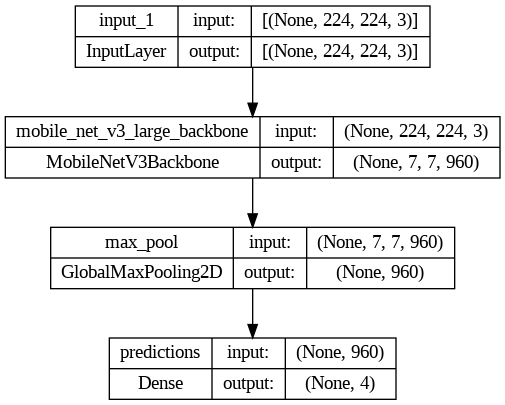

In [ ]:
keras.utils.plot_model(mobilenet_model, to_file = "mobilenet_model_architecture.png", show_shapes = True)

In [ ]:
mobilenet_model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobile_net_v3_large_backbo  (None, 7, 7, 960)         2996352   
 ne (MobileNetV3Backbone)                                        
                                                                 
 max_pool (GlobalMaxPooling  (None, 960)               0         
 2D)                                                             
                                                                 
 predictions (Dense)         (None, 4)                 3844      
                                                                 
Total params: 3000196 (11.44 MB)
Trainable params: 2975796 (11.35 MB)
Non-trainable params: 24400 (95.31 KB)
_________________________________________________________________


In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, accuracy_score, f1_score, recall_score

In [ ]:
def fit_model_and_save_logs(model, name:str, train_, valid_):
    # Initialize metrics list
    metrics = []

    # Extract true labels from the validation dataset
    true_values = [y for x, y in valid_.unbatch()]

    # Define callbacks
    es_cb = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode='auto',
        restore_best_weights=True
    )
    lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_best_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    csv_log = keras.callbacks.CSVLogger(
        filename = f"{name}_logs.csv",
        separator = ","
    )

    model.fit(
        train_,
        validation_data = valid_,
        callbacks = [es_cb, lr_cb, csv_log, checkpoint_cb],
        verbose = 2,
        epochs = NUM_EPOCHS,
        # Added inverse class weight
        class_weight=weight_dict
    )

    # Convert history to a DataFrame for easier plotting
    history_df = pd.DataFrame(model.history.history)
    # Plot accuracy and loss
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6), sharey = False)
    history_df[["accuracy", "val_accuracy"]].plot(ax = ax[0], title = "Accuracy vs Validation Accuracy", lw = 2)
    history_df[["loss", "val_loss"]].plot(ax = ax[1], title = "Loss vs Validation Loss", lw = 1.7)
    plt.savefig(f"{name}_train_val.png")

    # Predict on validation data
    preds = model.predict(valid_, verbose = 2)
    preds = np.argmax(preds, axis  = 1)

    # Calculate metrics
    accuracy_ = accuracy_score(true_values, preds) * 100
    precision_ = precision_score(true_values, preds, average="weighted") * 100
    f1_ = f1_score(true_values, preds, average="weighted") * 100
    recall_ = recall_score(true_values, preds, average="weighted") * 100
    metrics.extend([accuracy_, precision_, f1_, recall_])

    # Classification report
    cr = classification_report(true_values, preds, output_dict = True)
    cr = pd.DataFrame(cr)
    cr.columns = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo', 'accuracy', 'macro avg', 'weighted avg']
    cr = cr.T
    cr.to_csv(f"{name}_classification_report.csv", index = 1)

    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ConfusionMatrixDisplay.from_predictions(true_values, preds, cmap = "Blues", display_labels = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], ax = ax)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name}_confusion_matrix.jpg")

    metric_dataframe = pd.DataFrame(
            data = {"metrics": ["Accuracy", "Precision", "F1_Score", "Recall"],
                    "score": metrics,
                    "name": [f"{name}", f"{name}", f"{name}", f"{name}"]}
    )
    return metric_dataframe

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.24333, saving model to mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 76s - loss: 0.5030 - accuracy: 0.8371 - val_loss: 1.9491 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 76s/epoch - 269ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.24333
281/281 - 27s - loss: 0.1154 - accuracy: 0.9599 - val_loss: 2.7034 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 27s/epoch - 96ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.24333 to 0.25089, saving model to mobilenet_best_model.h5
281/281 - 27s - loss: 0.0463 - accuracy: 0.9845 - val_loss: 2.6238 - val_accuracy: 0.2509 - lr: 1.0000e-04 - 27s/epoch - 97ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.25089
281/281 - 27s - loss: 0.0266 - accuracy: 0.9929 - val_loss: 3.5984 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 27s/epoch - 96ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.25089 to 0.26557, saving model to mobilenet_best_model.h5
281/281 - 27s - loss: 0.0317 - accuracy: 0.9890 - val_loss: 3.9210 - val_accuracy: 0.2656 - lr: 1.0000e-04 - 27s/epoch - 97ms/step
Ep

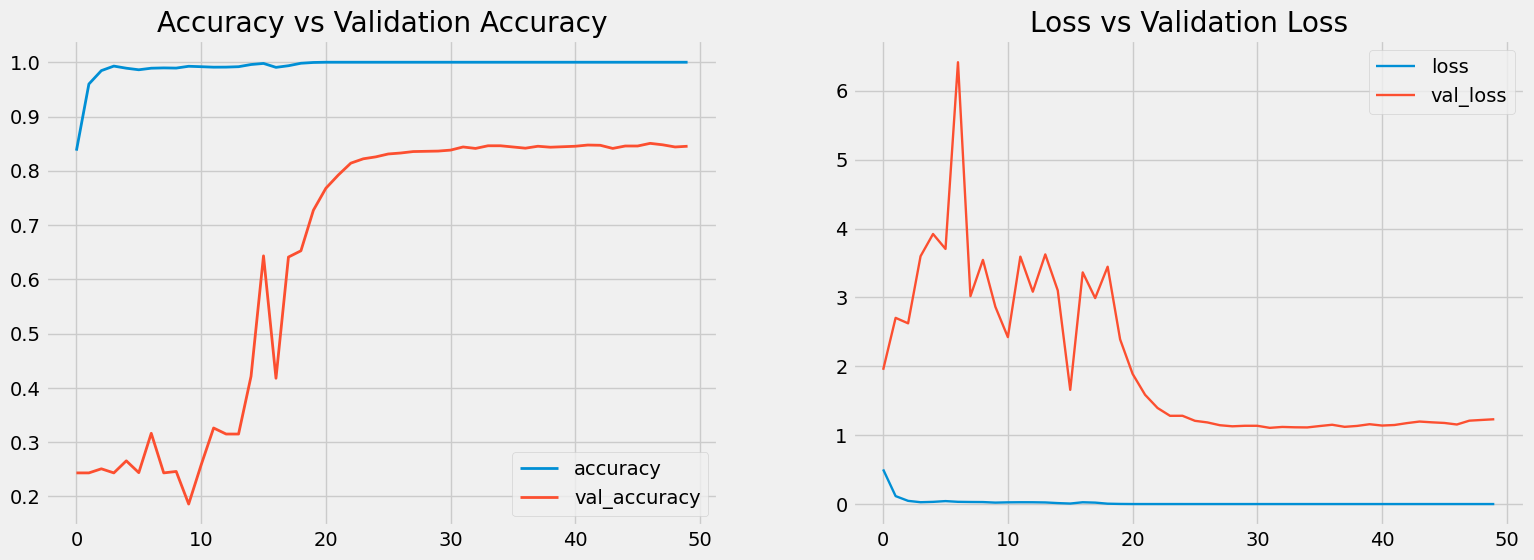

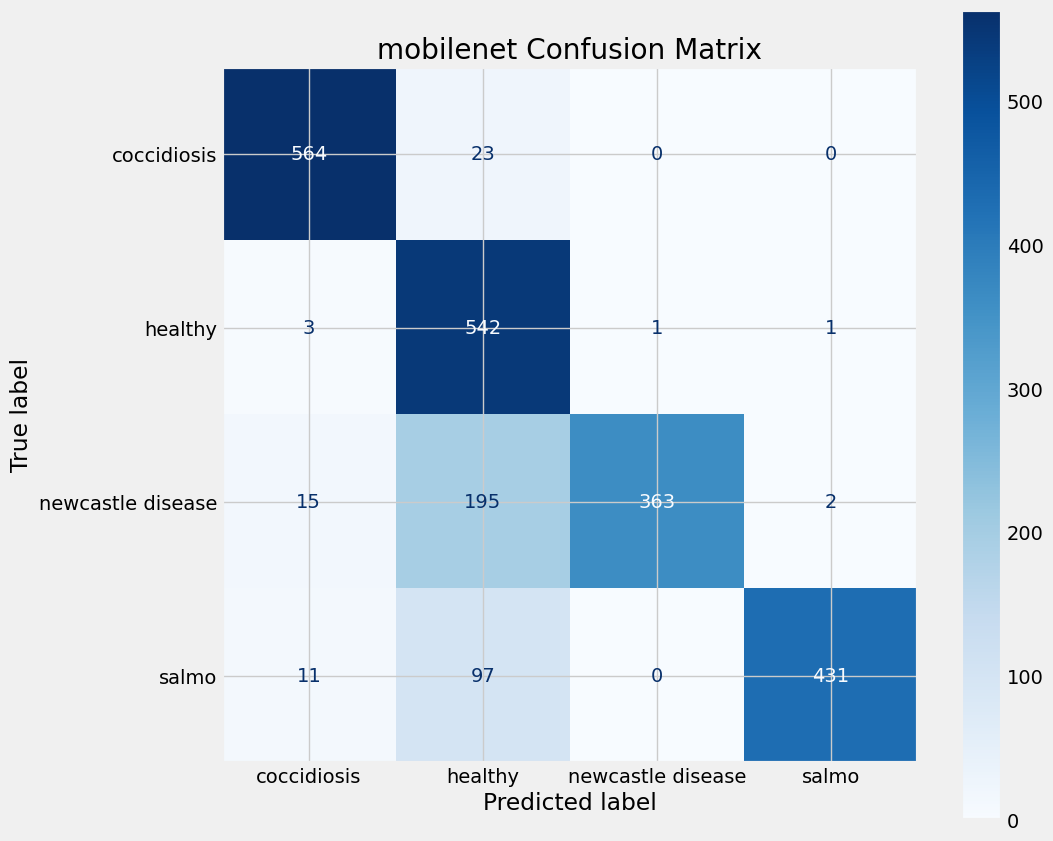

In [ ]:
# include_rescaling true
# 1_output
mn_metric_df_ = fit_model_and_save_logs(mobilenet_model, "mobilenet", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.82251, saving model to mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 68s - loss: 0.3391 - accuracy: 0.8941 - val_loss: 0.5979 - val_accuracy: 0.8225 - lr: 1.0000e-04 - 68s/epoch - 242ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.82251 to 0.90125, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0610 - accuracy: 0.9812 - val_loss: 0.3701 - val_accuracy: 0.9012 - lr: 1.0000e-04 - 26s/epoch - 93ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.90125 to 0.94217, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.2428 - val_accuracy: 0.9422 - lr: 1.0000e-04 - 26s/epoch - 93ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.94217 to 0.95018, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.1768 - val_accuracy: 0.9502 - lr: 1.0000e-04 - 26s/epoch - 94ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.95018 to 0.95418, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0161 - accuracy: 0.

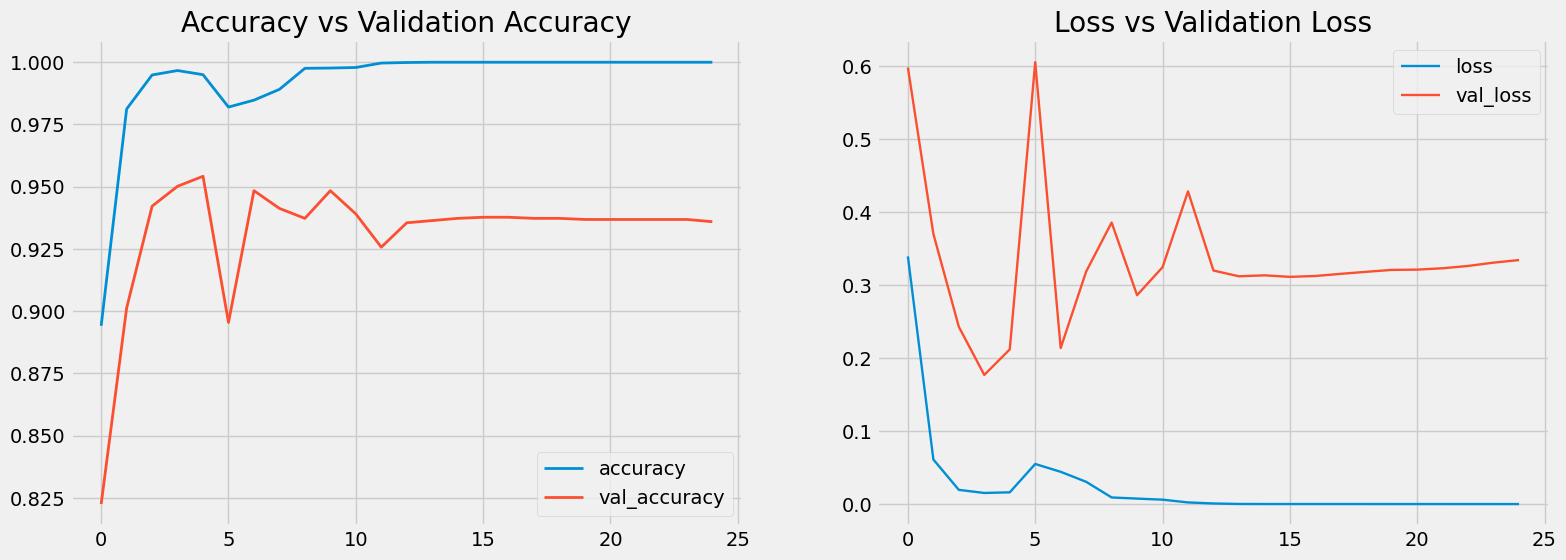

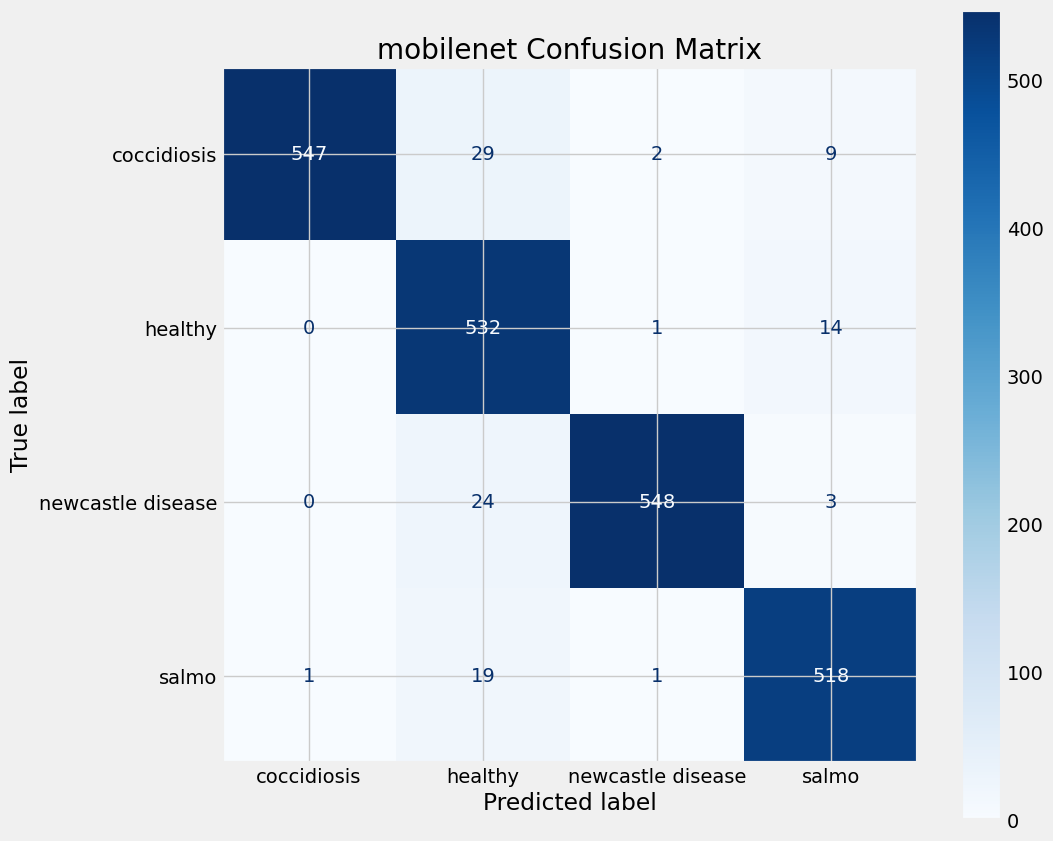

In [ ]:
# include_rescaling false
# 2_output
mn_metric_df_2 = fit_model_and_save_logs(mobilenet_model, "mobilenet", train_batch, valid_batch)

In [ ]:
mkdir output

In [ ]:
cp -r './output_2' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/3_MobileNetV3_output'